# 1.
Выясните, насколько охотно новые игроки «Королевства гномов» совершают покупки: рассчитайте и визуализируйте Conversion Rate.
Применяя функцию get_conversion(), получите сырые данные о количестве первых покупок, таблицу конверсии и таблицу динамики конверсии.
Момент анализа совпадает с максимальной датой привлечения пользователей и сохранён в переменной observation_date.
Задайте горизонт анализа — 7 дней.
Применяя функцию subplot(), постройте по таблице конверсии два графика — кривые конверсии и тепловую карту.
На график с кривыми конверсии добавьте сетку и сделайте лайфтаймы подписями по горизонтальной оси.
На хитмэп добавьте значения и отобразите их в виде процентов с точностью до двух знаков после запятой.
Данные о покупках сохранены в файле ch02_problems02_orders.csv.
Вот его структура:

    user_id — уникальный идентификатор пользователя,
    event_dt — дата и время совершения покупки;
    revenue — сумма покупки.

Подсказка
Установите горизонт анализа, присвоив переменной analysis_horizon значение 7.
Вызовите функцию get_conversion(), передав ей четыре аргумента: пользовательские профили — users, данные о покупках — purchases, момент анализа — observation_date, горизонт анализа — analysis_horizon.
Сохраните результат в трёх переменных, например conversion_raw, conversion и conversion_history.
Удалите столбец с размерами когорт из таблицы конверсии, вызвав метод drop() и передав ему список со столбцом cohort_size в качестве параметра columns.
Результат сохраните в новой переменной, например report.
Чтоб построить кривые конверсии, транспонируйте таблицу атрибутом T и вызовите метод plot().
Укажите True в качестве параметра grid, чтобы добавить на график сетку, и list(report.columns.values) — в качестве параметра xticks, чтобы сделать лайфтаймы подписями на оси X.
Задайте расположение графика функцией subplot() в параметре ax: ax=plt.subplot(1, 2, 1).
Тепловую карту постройте методом heatmap(), передав ему таблицу и такой набор параметров: annot=True, fmt='.2%', ax=plt.subplot(1, 2, 2).

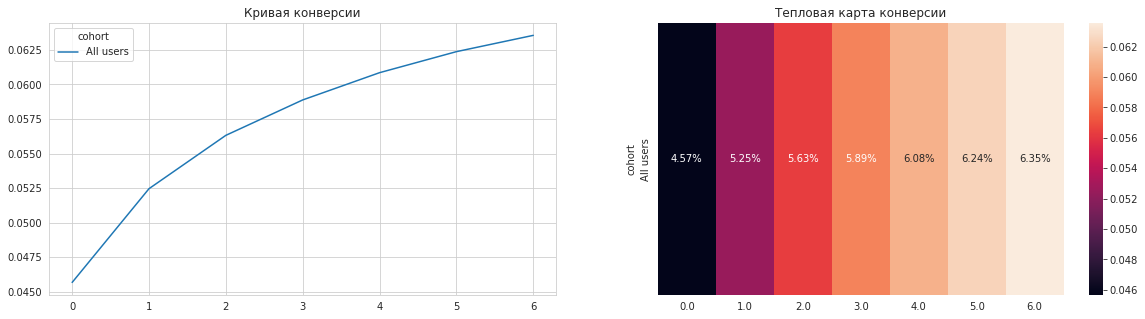

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

def get_conversion(
        profiles,
        purchases,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
            .groupby('user_id')
            .agg({'event_dt': 'first'})
            .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
            result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


# загружаем данные
users = pd.read_csv('datasets/ch02_problems02_users.csv')  # профили
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # покупки

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

observation_date = users['dt'].max()  # момент анализа

analysis_horizon = 7 # задайте горизонт анализа

retention_raw, retention, retention_history = get_conversion(profiles=users,
                                                             purchases=purchases,
                                                             observation_date=observation_date,
                                                             horizon_days=analysis_horizon)
# получите сырые данные, таблицу конверсии и таблицу динамики конверсии

plt.figure(figsize=(20, 5)) # размер сетки для графиков
report = retention.drop(columns = 'cohort_size')
# удалите столбец с размерами когорт из таблицы конверсии

# тоб построить кривые конверсии, транспонируйте таблицу атрибутом T и вызовите метод plot().
# Укажите True в качестве параметра grid, чтобы добавить на график сетку, и list(report.columns.values) — в качестве параметра xticks, чтобы сделать лайфтаймы подписями на оси X.
# Задайте расположение графика функцией subplot() в параметре ax: ax=plt.subplot(1, 2, 1).
# Тепловую карту постройте методом heatmap(), передав ему таблицу и такой набор параметров: annot=True, fmt='.2%', ax=plt.subplot(1, 2, 2).
# постройте кривые конверсии

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1)
)  # во второй — кривые конверсии
plt.title('Кривая конверсии')
# постройте тепловую карту
sns.heatmap(report,
            annot=True, fmt='.2%', ax=plt.subplot(1, 2, 2))
plt.title('Тепловая карта конверсии')

plt.show()

# 2.
Важная задача маркетологов — распределять рекламный бюджет.
Помогите им найти источники, которые привлекают в «Королевство гномов» самых «качественных» игроков.
Для этого рассчитайте конверсию с разбивкой по каналам привлечения из channel.
Используя таблицу динамики конверсии, во второй ячейке таблицы графиков визуализируйте историю изменений конверсии 7-го дня с разбивкой по каналам привлечения.
Добавьте на график сетку.

Подсказка
Вызовите функцию get_conversion(), передав ей такие аргументы: users, purchases, observation_date, analysis_horizon и dimensions=['channel'].
Чтобы построить график истории изменений, преобразуйте таблицу динамики конверсии:

    Сделайте срез данных за шестой лайфтайм: conversion_history[6].
    Восстановите числовые индексы методом reset_index().
    Постройте сводную таблицу методом pivot_table(), передав ему параметры index='dt', columns='channel', values=6 и aggfunc='mean'.
    Заполните возможные пропуски методом fillna(0).

Затем постройте график по преобразованной таблице динамики конверсии, вызвав метод plot() и передав ему такие аргументы: grid=True и ax=plt.subplot(1, 2, 2).

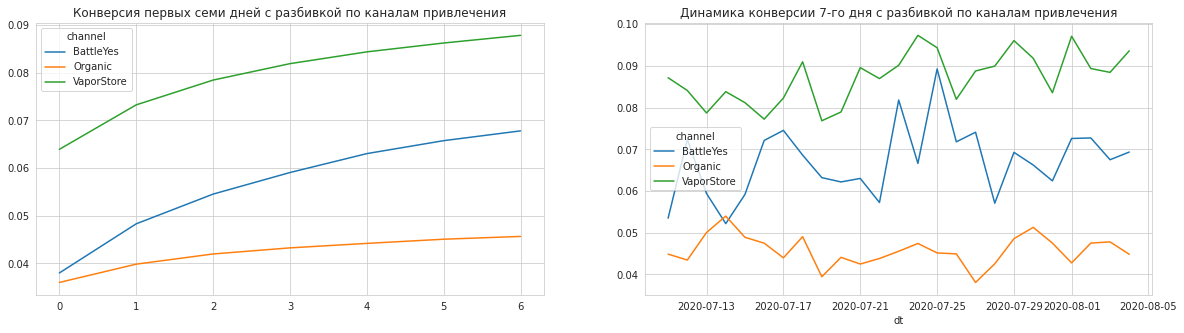

In [4]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

def get_conversion(
        profiles,
        purchases,
        observation_date,
        horizon_days,
        dimensions=[],
        ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
            .groupby('user_id')
            .agg({'event_dt': 'first'})
            .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
            result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


# загружаем данные
users = pd.read_csv('datasets/ch02_problems02_users.csv')  # профили
purchases = pd.read_csv('datasets/ch02_problems02_orders.csv')  # покупки

# преобразование данных о времени
users['dt'] = pd.to_datetime(users['dt']).dt.date
users['first_ts'] = pd.to_datetime(users['first_ts'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

observation_date = users['dt'].max()  # момент анализа

analysis_horizon = 7  # горизонт анализа

conversion_raw, conversion, conversion_history = get_conversion(profiles=users,
                                                             purchases=purchases,
                                                             observation_date=observation_date,
                                                             horizon_days=analysis_horizon,
                                                             dimensions=['channel'])
# получите сырые данные, таблицу конверсии и таблицу динамики конверсии

plt.figure(figsize=(20, 5)) # размер сетки для графиков

# в одной ячейке — кривые конверсии
report = conversion.drop(columns=['cohort_size'])

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1)
)
plt.title('Конверсия первых семи дней с разбивкой по каналам привлечения')

(conversion_history[6].
 reset_index().
 pivot_table(index='dt', columns='channel', values=6, aggfunc='mean')
 .plot(grid=True, ax=plt.subplot(1, 2, 2)))
# во второй ячейке постройте график истории изменений
# выберите нужный день «жизни» и постройте сводную таблицу
# постройте график и задайте его параметры
plt.title('Динамика конверсии 7-го дня с разбивкой по каналам привлечения')

plt.show()